***Importing all the Necessary libraries***

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import matplotlib.image as mpimg
import random
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
import pathlib
import numpy as np

***Definning the dataset path***
* *os.walk() function: to traverse a directory tree starting from the path "../input/fruit-recognition".*
* *The current directory path is stored in the variable dirpath, the list of subdirectory names is stored in the variable dirnames, and the list of filenames is stored in the variable filenames.*

In [ ]:
for dirpath, dirnames, filenames in os.walk("../input/fruit-recognition"):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

***Setting path for TRAIN AND TEST***

In [ ]:
train_path = "../input/fruit-recognition/train/train/"
test_path = "../input/fruit-recognition/test/test/"

***Getting the Different class names from the directory***

In [ ]:
data_dir = pathlib.Path(train_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

[]


***Plot a grid of images from a training dataset***

In [ ]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 100)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  return img

IndexError: ignored

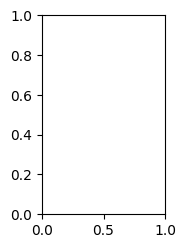

In [ ]:
plt.figure(figsize = (15,15))
# View a random image from the training dataset for all classes
for i in range(33):
    plt.subplot(5,8,i+1)
    img = view_random_image(target_dir=train_path,
                        target_class=class_names[i])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# New Section

***Preparing VALIDATION Data***

*Collects Information about the training dataset by traversing the directory tree using os.walk() and populating a dictionary called train_val_data.*

In [ ]:
train_val_data = {'path' : [],
       'filename': [],
       'label': []}
for dirpath, dirnames, filenames in os.walk(train_path):
    for f in filenames:
        train_val_data['path'].append(dirpath)
        train_val_data['filename'].append(f)
        train_val_data['label'].append(f.split('_')[0])

In [ ]:
train_val_data_df = pd.DataFrame(train_val_data)
train_val_data_df.head()

***Prepare the Testing Data***

In [ ]:
#Read test data and create a dataframe
test_data = {'path' : [],
       'filename': []}
for dirpath, dirnames, filenames in os.walk(test_path):
    for f in filenames:
        test_data['path'].append(dirpath)
        test_data['filename'].append(f)

In [ ]:
test_data_df = pd.DataFrame(test_data)
test_data_df.head()

***Read Images and create numpy data array***

In [ ]:

images = []
label = []

for _, d in train_val_data_df.iterrows():
    img = load_img(os.path.join(d['path'],d['filename']))
    images.append(img_to_array(img))
    label.append(d['label'])

In [ ]:
images = np.array(images)
labels = np.array(label)
print(f"Complete data images shape: {images.shape} and label shape: {labels.shape}")

In [ ]:
test_images = []

for _, d in test_data_df.iterrows():
    img = load_img(os.path.join(d['path'],d['filename']))
    test_images.append(img_to_array(img))

test_images = np.array(test_images)
print(f"Test images shape: {test_images.shape} ")

***Label Encoding***

In [ ]:
class_indices = dict(zip(class_names, range(len(class_names))))

labels_encoded = list(map(class_indices.get, labels))

#Convert to categorical data using tensorflow
#labels to One-hot encoded
label_categorical = tf.keras.utils.to_categorical(labels_encoded, num_classes=len(class_names), dtype='uint8')


***Train And Validation split***

In [ ]:
train_im, valid_im, train_lab, valid_lab = train_test_split(images, label_categorical, test_size=0.20,
                                                            stratify=label_categorical,
                                                            random_state=40, shuffle = True)

In [ ]:
print ("train data shape after the split: ", train_im.shape)
print ('new validation data shape: ', valid_im.shape)
print ("validation labels shape: ", valid_lab.shape)

In [ ]:
print ('train im and label types: ', type(train_im), type(train_lab))

training_data = tf.data.Dataset.from_tensor_slices((train_im, train_lab))
validation_data = tf.data.Dataset.from_tensor_slices((valid_im, valid_lab))
test_data = tf.data.Dataset.from_tensor_slices(test_images)

print ('check types; ', type(training_data), type(validation_data), type(test_data))

In [ ]:
### check using element_spec

print (training_data.element_spec)
print (validation_data.element_spec)

### as expected, tensors of image and original label shape


### create an iterator and turn it into numpy array
train_iter = iter(training_data)
print(next(train_iter)[0].numpy(), '\n', next(train_iter)[1].numpy(), np.argmax(next(train_iter)[1].numpy()))

In [ ]:
train_iter_im, train_iter_label = next(iter(training_data))
print (train_iter_im.numpy().shape, train_iter_label.numpy().shape)

In [ ]:
train_iter_im1, train_iter_label1 = next(training_data.as_numpy_iterator())
print (train_iter_im1.shape, train_iter_label1.shape)

In [ ]:
check_list = list(training_data.as_numpy_iterator())
print (len(check_list), check_list[1])

In [ ]:

fig = plt.figure(figsize=(10,10))
for i in range(12):
    plt.subplot(4,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(check_list[i][0]/255.)
    plt.xlabel(class_names[np.argmax(check_list[i][1])], fontsize=13)
plt.tight_layout()
plt.show()

***Data Pipeline using`tf.data` & Prefetching***

In [ ]:
rescale_data = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1/255.)
])

data_augmenation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip(mode = "horizontal"),
    #layers.experimental.preprocessing.RandomRotation(0.1)
])

In [ ]:
random_image_index = random.randint(0,len(train_im))
img = rescale_data(train_im[random_image_index])
img = data_augmenation(img)
plt.imshow(img)

In [ ]:
BATCH_SIZE = 128
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment = False, test = False):
    if test:
        ds = ds.map(lambda x: (rescale_data(x)), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x, y: (rescale_data(x), y), num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    #batch the data
    ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmenation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
train_ds = prepare(training_data, shuffle = True, augment = True)
val_ds = prepare(validation_data)
test_ds = prepare(test_data, test=True)

***CNN Model***
* *The model consists of a convolutional layer, a max pooling layer, a flatten layer, and a dense (fully connected) layer with a softmax activation function*

In [ ]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=5,
                          kernel_size = 3,
                          activation = "relu",
                          input_shape = (100,100,3)),
    tf.keras.layers.MaxPool2D(pool_size =2,
                             padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])

model_1.compile(loss="categorical_crossentropy",
               optimizer = tf.keras.optimizers.Adam(),
               metrics = ['accuracy'])

In [ ]:
model_1.summary()

***Fitting The Model***

In [ ]:
#Fit the model on training data
history_1 = model_1.fit(train_ds,
                       epochs =25,
                       validation_data= val_ds)

***Plotting Graph for loss & accuracy***

In [ ]:
#loss and accuracy plot
pd.DataFrame(history_1.history).plot()

***Saving The Model***

In [ ]:
model_1.save('model.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/kaggle/working/model.h5')

In [ ]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(224, 224))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_array / 255.0

    return img_preprocessed